#**Proyek Predictive Analysis : Prediksi Penyakit Kanker Pankreas Pada Manusia**

### by : Baharuddin Nur Maulana

##Import Library

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

##Import Kaggle

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"baharuddinnurm","key":"dfbbd9dfa2f0bc24956bc3c4ff6092ae"}'}

In [4]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer

  0% 0.00/18.0k [00:00<?, ?B/s]
100% 18.0k/18.0k [00:00<00:00, 9.12MB/s]


In [6]:
! unzip urinary-biomarkers-for-pancreatic-cancer.zip

Archive:  urinary-biomarkers-for-pancreatic-cancer.zip
  inflating: Debernardi et al 2020 data.csv  
  inflating: Debernardi et al 2020 documentation.csv  


##Data Understanding

## Import Dataset

In [7]:
df=pd.read_csv('Debernardi et al 2020 data.csv')
df

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.948840,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.467030,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.366000,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.579000,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.540000,41.088000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,S549,Cohort2,BPTB,68,M,3,IV,NaN,NaN,0.52026,7.058209,156.241000,525.178000,NaN
586,S558,Cohort2,BPTB,71,F,3,IV,NaN,NaN,0.85956,8.341207,16.915000,245.947000,NaN
587,S560,Cohort2,BPTB,63,M,3,IV,NaN,NaN,1.36851,7.674707,289.701000,537.286000,NaN
588,S583,Cohort2,BPTB,75,F,3,IV,NaN,NaN,1.33458,8.206777,205.930000,722.523000,NaN


Dari dataset diatas, kita dapat melihat bahwa dataset tersebut memiliki 590 baris dan 14 kolom.

In [8]:
df.isnull().sum()

sample_id                    0
patient_cohort               0
sample_origin                0
age                          0
sex                          0
diagnosis                    0
stage                      391
benign_sample_diagnosis    382
plasma_CA19_9              240
creatinine                   0
LYVE1                        0
REG1B                        0
TFF1                         0
REG1A                      284
dtype: int64

Dari informasi diatas, menunjukkan terjadinya missing value pada beberapa kolom dataset, diantaranya pada kolom stage, benign_sample_diagnosis, plasma_CA19_9 dan REG1A.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64
dtypes: float64(6), int64(2), o

In [10]:
df.describe()

,age,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
count,590.000000,590.000000,350.000000,590.000000,590.000000,590.000000,590.000000,306.000000
mean,59.079661,2.027119,654.002944,0.855383,3.063530,111.774090,597.868722,735.281222
std,13.109520,0.804873,2430.317642,0.639028,3.438796,196.267110,1010.477245,1477.247724
min,26.000000,1.000000,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000
25%,50.000000,1.000000,8.000000,0.373230,0.167179,10.757216,43.961000,80.692000
50%,60.000000,2.000000,26.500000,0.723840,1.649862,34.303353,259.873974,208.538500
75%,69.000000,3.000000,294.000000,1.139482,5.205037,122.741013,742.736000,649.000000
max,89.000000,3.000000,31000.000000,4.116840,23.890323,1403.897600,13344.300000,13200.000000


##Visualisasi Data

**Distribusi Kolom Kategorial**

   Total Sampel  Persentase
2           208        35.3
3           199        33.7
1           183        31.0


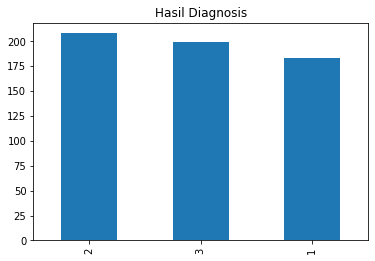

In [11]:
categorical_fitur = ['diagnosis']
numerical_fitur =['age', 'plasma_CA19-9', 'creatinine', 'LYVE1', 'REG1B', 'TEF1', 'REG1A']
fitur = categorical_fitur[0]
count = df[fitur].value_counts()
persen = 100*df[fitur].value_counts(normalize=True)
data = pd.DataFrame({'Total Sampel':count,
                     'Persentase':persen.round(1)})
print (data)
count.plot(kind='bar', title='Hasil Diagnosis');

Pada Hasil diagnosis, jika dilihat terdapat 3 jenis nilai. 3 jenis nilai tersebut merepresentasikan kondisi pankreas manusia. Dalam hal ini, nilai 1 merepresentasikan bahwa kondisi pankreas sehat, nilai 2 merepresentasikan bahwa kondisi pankreas non kanker dan nilai 3 merepresentasikan bahwa kondisi kanker pankreas(pasien dengan adenokarsinoma duktus pankreas).

**Distribusi Kolom Numerikal**

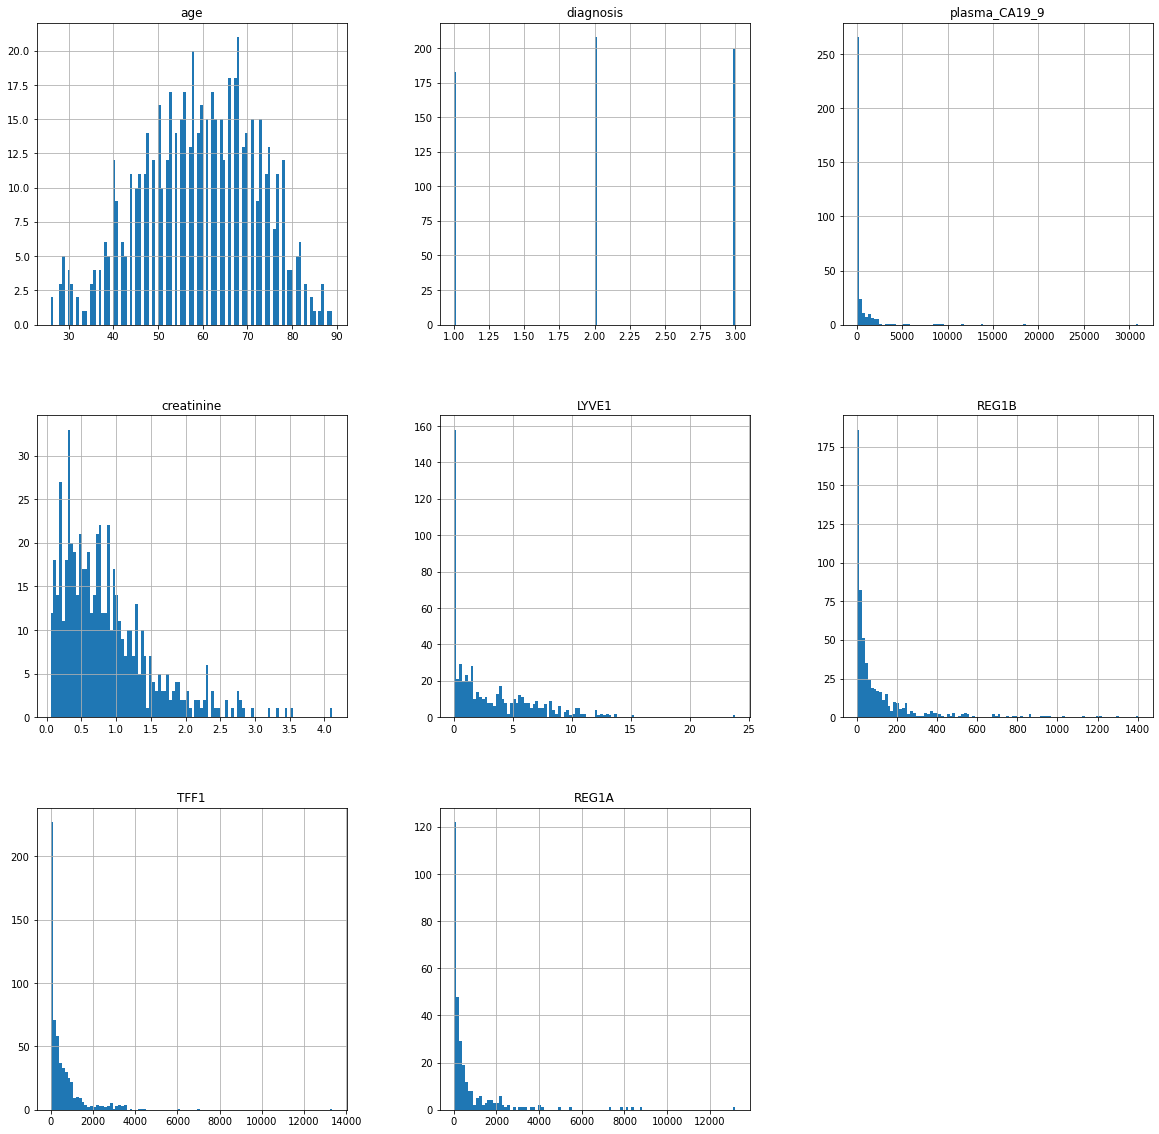

In [12]:
df.hist(bins=100,
        figsize=(20,20))
plt.show()

**Correlation Matrix**

Text(0.5, 1.0, 'Correlation Matrix for Numerix Feature')

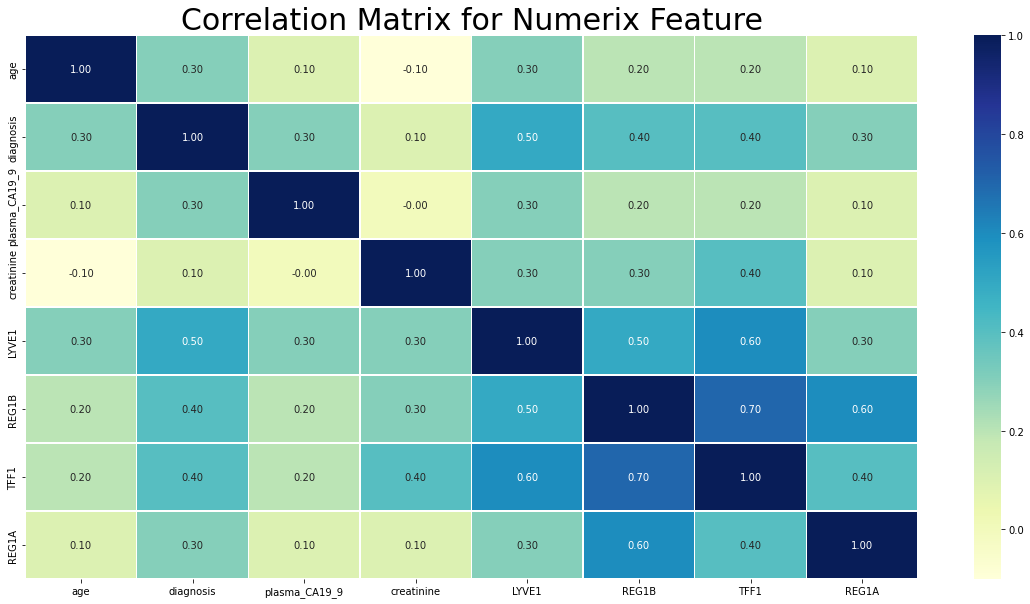

In [13]:
df.corr()
plt.figure(figsize=(20,10))
korelasi_matrix = df.corr().round(1)
sns.heatmap(korelasi_matrix,
            annot=True,
            linewidths=0.5,
            fmt='.2f',
            cmap='YlGnBu')
plt.title("Correlation Matrix for Numerix Feature", size=30)

##Data Preparation

Melakukan drop kolom pada fitur sample_id, patient_cohort, sample_origin, stage, dan benign_sample_diagnosis. Hal ini dilakukan karena proyek ini berfokus pada deteksi pasien terkana penyakit kanker pankreas atau tidak, sehingga beberapa fitur tersebut tidak diperlukan.

In [14]:
df = df.drop(columns=['sample_id', 'patient_cohort', 'sample_origin', 'stage', 'benign_sample_diagnosis'])
df.head()

,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,33,F,1,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,81,F,1,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,51,M,1,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,61,M,1,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,62,M,1,9.0,0.21489,0.000860,65.54000,41.088000,NaN


Melakukan penanganan missing value terhadap dataset yang digunakan. Hal ini dilakukan, karena masih terdapat banyak missing value pada kolom/fitur dataset sehingga harus diatas dengan melakukan perhitungan nilai rata-rata(mean) pada kolom yang bermasalah.

In [15]:
for a in df[:]:
  if a!='sex':
    df[a] = df[a].fillna(df[a].mean())
df.head()

,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,33,F,1,11.700000,1.83222,0.893219,52.94884,654.282174,1262.000000
1,81,F,1,654.002944,0.97266,2.037585,94.46703,209.488250,228.407000
2,51,M,1,7.000000,0.78039,0.145589,102.36600,461.141000,735.281222
3,61,M,1,8.000000,0.70122,0.002805,60.57900,142.950000,735.281222
4,62,M,1,9.000000,0.21489,0.000860,65.54000,41.088000,735.281222


Melakukan pengecekan terhadap dataset yang telah di drop dan telah dilakukan penanganan missing value. Pengecekan tersebut dilakukan dengan menggunakan isnull().sum()

In [16]:
df.isnull().sum()

age              0
sex              0
diagnosis        0
plasma_CA19_9    0
creatinine       0
LYVE1            0
REG1B            0
TFF1             0
REG1A            0
dtype: int64

**Data Unique**

Melakukan pengecekan data unique, agar mempermudah proses analisis

In [17]:
df['diagnosis'].unique()

array([1, 2, 3])

**Mapping Diagnosis**

Melakukan mapping/replace terhadap kolom diagnosis dari type object ke numerik agar bisa dibaca mesin. Oleh karena itu, pada proyek ini nilainya akan diubah dan hanya akan digolongkan ke 2 nilai yaitu 0 sebagai indikator bahwa bukan penderita kanker dan 1 sebagai indikator bahwa pasien terkena kanker pankreas.

In [18]:
df['diagnosis'].replace([1,2,3],
                        [0,0,1],
                        inplace=True)
df

,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,33,F,0,11.700000,1.83222,0.893219,52.948840,654.282174,1262.000000
1,81,F,0,654.002944,0.97266,2.037585,94.467030,209.488250,228.407000
2,51,M,0,7.000000,0.78039,0.145589,102.366000,461.141000,735.281222
3,61,M,0,8.000000,0.70122,0.002805,60.579000,142.950000,735.281222
4,62,M,0,9.000000,0.21489,0.000860,65.540000,41.088000,735.281222
...,...,...,...,...,...,...,...,...,...
585,68,M,1,654.002944,0.52026,7.058209,156.241000,525.178000,735.281222
586,71,F,1,654.002944,0.85956,8.341207,16.915000,245.947000,735.281222
587,63,M,1,654.002944,1.36851,7.674707,289.701000,537.286000,735.281222
588,75,F,1,654.002944,1.33458,8.206777,205.930000,722.523000,735.281222


Melakukan proses one-hot-encoding, yang berfungsi untuk mengubah variabel kategorikal menjadi variabel numerikal.

In [19]:
df = pd.get_dummies(df)
df

,age,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A,sex_F,sex_M
0,33,0,11.700000,1.83222,0.893219,52.948840,654.282174,1262.000000,1,0
1,81,0,654.002944,0.97266,2.037585,94.467030,209.488250,228.407000,1,0
2,51,0,7.000000,0.78039,0.145589,102.366000,461.141000,735.281222,0,1
3,61,0,8.000000,0.70122,0.002805,60.579000,142.950000,735.281222,0,1
4,62,0,9.000000,0.21489,0.000860,65.540000,41.088000,735.281222,0,1
...,...,...,...,...,...,...,...,...,...,...
585,68,1,654.002944,0.52026,7.058209,156.241000,525.178000,735.281222,0,1
586,71,1,654.002944,0.85956,8.341207,16.915000,245.947000,735.281222,1,0
587,63,1,654.002944,1.36851,7.674707,289.701000,537.286000,735.281222,0,1
588,75,1,654.002944,1.33458,8.206777,205.930000,722.523000,735.281222,1,0


##Split pada Dataset

Melakukan pembagian dataset menjadi dengan 80% untuk data latih dan 20% untuk data uji. Pembagian dataset ini menggunakan modul train_test_split dari scikit-learn.

In [20]:
x = df.drop('diagnosis',axis=1)
y = df['diagnosis']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=5)

In [21]:
print(f'Total of sample in whole dataset: {len(x)}')
print(f'Total of sample in train dataset: {len(x_train)}')
print(f'Total of sample in test dataset: {len(x_test)}')

Total of sample in whole dataset: 590
Total of sample in train dataset: 472
Total of sample in test dataset: 118


##Standard Scaler

Melakukan normalisasi pada data dengan menggunakan Standard Scaler (MinMaxScaler)

In [22]:
sc = MinMaxScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

## Modelling

**Model KNN**

In [23]:
models = pd.DataFrame(index=['train_mse', 'test_mse'],
                      columns=['KNN', 'RandomForest', 'SVM'])

In [24]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [25]:
knn_prediksi = knn.predict(x_test)
accuracy_score(y_test, knn_prediksi)

0.8220338983050848

In [26]:
from sklearn.metrics import accuracy_score, classification_report
knn_cr = classification_report(y_test, knn_prediksi, output_dict=True)
pd.DataFrame(knn_cr).transpose()

,precision,recall,f1-score,support
0,0.864865,0.853333,0.859060,75.000000
1,0.750000,0.767442,0.758621,43.000000
accuracy,0.822034,0.822034,0.822034,0.822034
macro avg,0.807432,0.810388,0.808841,118.000000
weighted avg,0.823007,0.822034,0.822459,118.000000


**Model Random Forest**

In [27]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [28]:
rf_prediksi = rf.predict(x_test)
accuracy_score(y_test, rf_prediksi)

0.8389830508474576

In [29]:
rf_cr = classification_report(y_test, rf_prediksi, output_dict=True)
pd.DataFrame(rf_cr).transpose()

,precision,recall,f1-score,support
0,0.858974,0.893333,0.875817,75.000000
1,0.800000,0.744186,0.771084,43.000000
accuracy,0.838983,0.838983,0.838983,0.838983
macro avg,0.829487,0.818760,0.823451,118.000000
weighted avg,0.837484,0.838983,0.837652,118.000000


**Model SVM**

In [30]:
svm = SVC()
svm.fit(x_train, y_train)

SVC()

In [31]:
svm_prediksi = svm.predict(x_test)
accuracy_score(y_test, knn_prediksi)

0.8220338983050848

In [32]:
svm_cr = classification_report(y_test, svm_prediksi, output_dict=True)
pd.DataFrame(svm_cr).transpose()

,precision,recall,f1-score,support
0,0.827160,0.893333,0.858974,75.000000
1,0.783784,0.674419,0.725000,43.000000
accuracy,0.813559,0.813559,0.813559,0.813559
macro avg,0.805472,0.783876,0.791987,118.000000
weighted avg,0.811354,0.813559,0.810153,118.000000


##Evaluation

**Perbandingan Matrix antar model**

In [33]:
metrics = pd.DataFrame({'accuracy' : [knn_cr['accuracy'], rf_cr['accuracy'], svm_cr['accuracy']], 
                        'f1-score_0' : [knn_cr['0']['f1-score'], rf_cr['0']['f1-score'], svm_cr['0']['f1-score']],
                        'precision_0' : [knn_cr['0']['precision'], rf_cr['0']['precision'], svm_cr['0']['precision']],
                        'recall_0' : [knn_cr['0']['recall'], rf_cr['0']['recall'], svm_cr['0']['recall']],
                        'f1-score_1' : [knn_cr['1']['f1-score'], rf_cr['1']['f1-score'], svm_cr['1']['f1-score']],
                        'precision_1' : [knn_cr['1']['precision'], rf_cr['1']['precision'], svm_cr['1']['precision']],
                        'recall_1' : [knn_cr['1']['recall'], rf_cr['1']['recall'], svm_cr['1']['recall']]},
                        index=['KNN','RF','SVM'])
multiheader = [('','accuracy'),
               ('0', 'f1-score'),
               ('0', 'precision'),
               ('0', 'recall'),
               ('1', 'f1-score'),
               ('1', 'precision'),
               ('1', 'recall')]
metrics.columns = pd.MultiIndex.from_tuples(multiheader)
# Menampilkan dataframe
metrics

0                             1                    
     accuracy  f1-score precision    recall  f1-score precision    recall
KNN  0.822034  0.859060  0.864865  0.853333  0.758621  0.750000  0.767442
RF   0.838983  0.875817  0.858974  0.893333  0.771084  0.800000  0.744186
SVM  0.813559  0.858974  0.827160  0.893333  0.725000  0.783784  0.674419

##Confussion Matrix

**Visualisasi Confussion Matrix KNN**

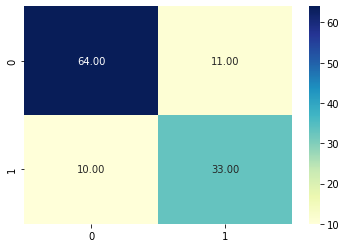

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix
knn_cm = confusion_matrix(y_test, knn_prediksi)
sns.heatmap(knn_cm,
            annot=True,
            fmt='.2f',
            cmap='YlGnBu')

**Visualisasi Confussion Matrix Random Forest**

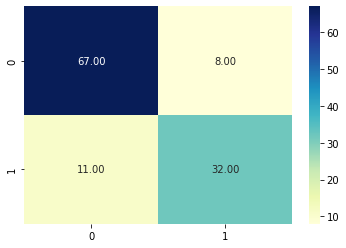

In [35]:
rf_cm = confusion_matrix(y_test, rf_prediksi)
sns.heatmap(rf_cm,
            annot=True,
            fmt='.2f',
            cmap='YlGnBu')

**Visualisasi Confussion Matrix SVM**

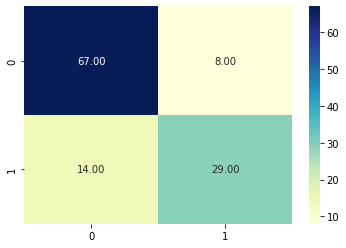

In [36]:
svm_cm = confusion_matrix(y_test, svm_prediksi)
sns.heatmap(svm_cm,
            annot=True,
            fmt='.2f',
            cmap='YlGnBu')